<a href="https://colab.research.google.com/github/Chtholly000/simplified-cnn-fer/blob/main/Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All libraries imported successfully.

--- Setting up Kaggle API ---
Please upload your 'kaggle.json' file:


Saving kaggle.json to kaggle.json
Kaggle API key configured successfully.

--- Downloading FER2013 dataset from Kaggle ---
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 839MB/s]
Unzipping dataset...
Dataset unzipped successfully.

Image folder transforms are defined.
CNN Model 2 class is defined.
Using device: cuda

Successfully loaded FER2013 dataset using ImageFolder.
Training set size: 28709
Validation set size: 7178
Classes found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Loss function: CrossEntropyLoss()

--- Starting Training ---
Epoch [01/50], Train Loss: 1.8194, Val Loss: 1.6942, Val Accuracy: 32.88%
Epoch [02/50], Train Loss: 1.6175, Val Loss: 1.5361, Val Accuracy: 41.20%
Epoch [03/50], Train Loss: 1.4618, Val Loss: 1.4408, Val Accuracy: 41.93%
Epoch [04/50], Train Loss: 1.3852, Val Loss: 1.2861, Val Accuracy: 50.10%
Epoch [05/50], Train Loss: 1.3072, V

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Visualizing Model Predictions ---


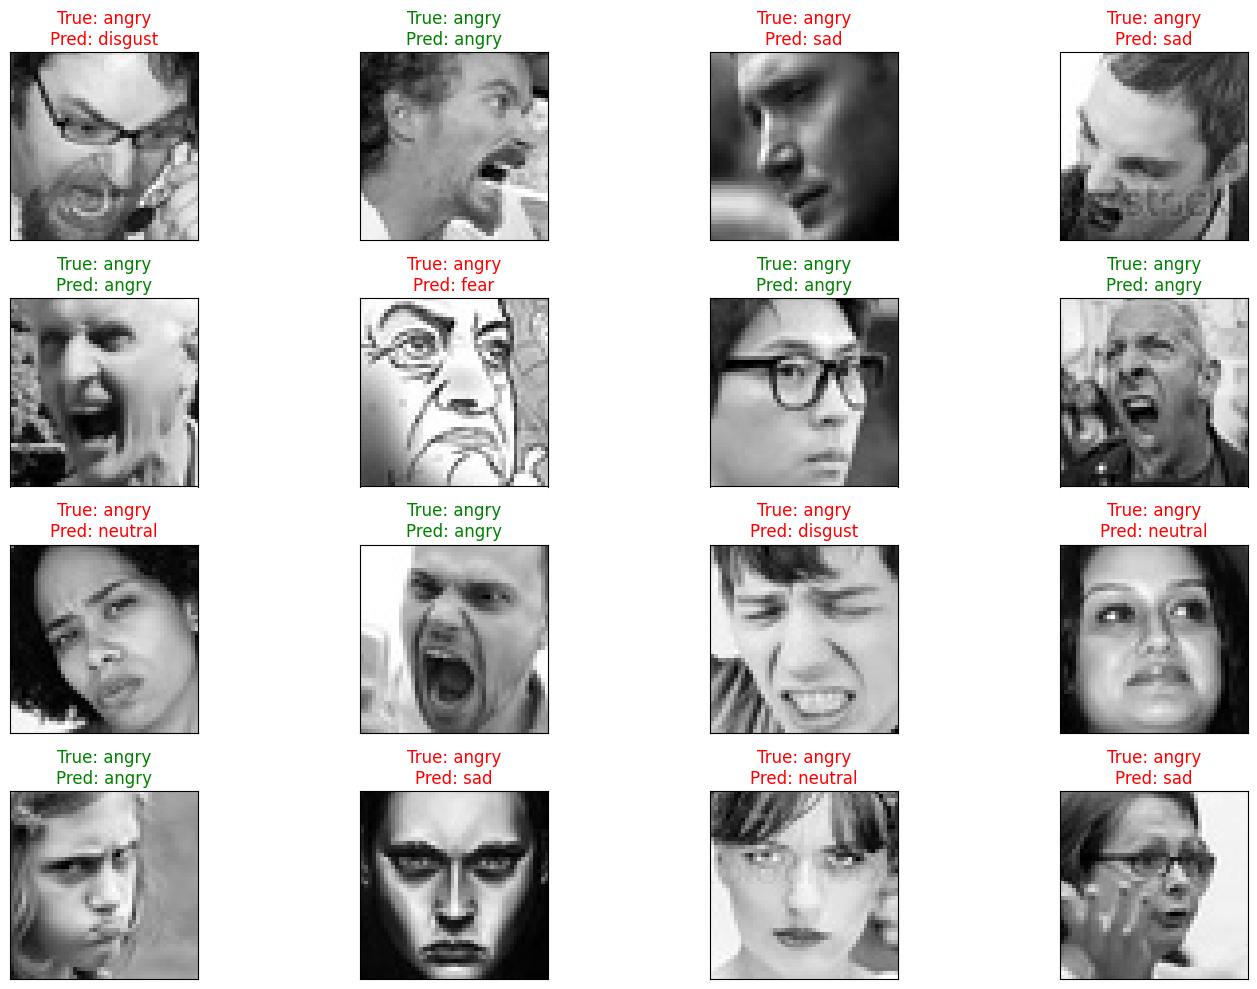


--- Plotting Training History ---


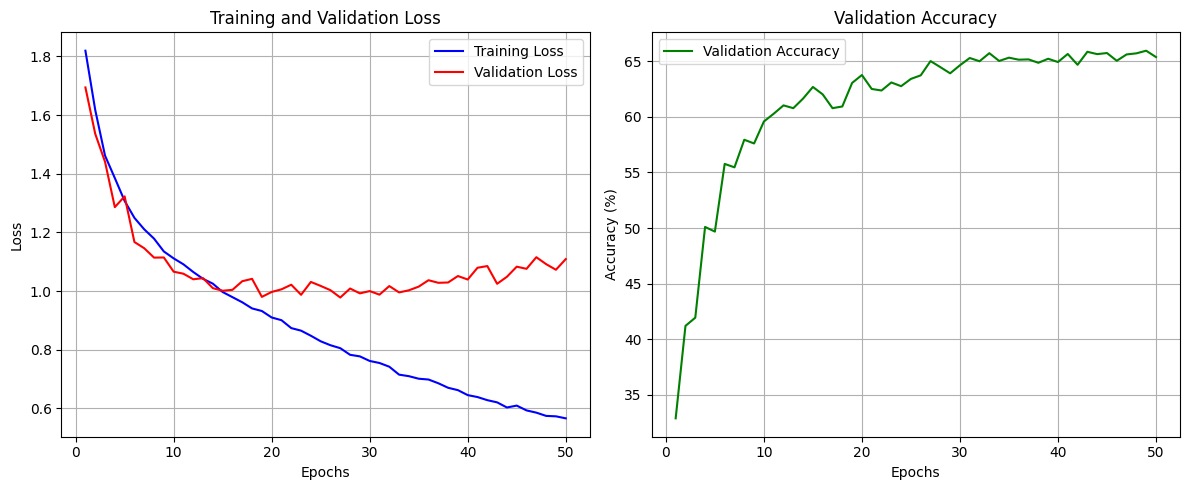

In [1]:
# ==============================================================================
# PART 1: IMPORTS AND SETUP
# ==============================================================================
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from google.colab import files
import zipfile

print("All libraries imported successfully.")

# ==============================================================================
# PART 2: KAGGLE API SETUP & DATA DOWNLOAD
# ==============================================================================
print("\n--- Setting up Kaggle API ---")
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your 'kaggle.json' file:")
    try:
        uploaded = files.upload()
        os.makedirs('/root/.kaggle', exist_ok=True)
        os.rename(list(uploaded.keys())[0], '/root/.kaggle/kaggle.json')
        os.chmod('/root/.kaggle/kaggle.json', 600)
        print("Kaggle API key configured successfully.")
    except Exception as e:
        print(f"\nCould not configure Kaggle API key. Error: {e}")
        exit()
else:
    print("Kaggle API key already exists.")

print("\n--- Downloading FER2013 dataset from Kaggle ---")
DATA_ROOT_DIR = 'fer2013_images'
if not os.path.exists(DATA_ROOT_DIR):
    !kaggle datasets download -d msambare/fer2013
    print("Unzipping dataset...")
    with zipfile.ZipFile('fer2013.zip', 'r') as zip_ref:
        zip_ref.extractall(DATA_ROOT_DIR)
    print("Dataset unzipped successfully.")
else:
    print("Dataset directory already exists. Skipping download and unzip.")

# ==============================================================================
# PART 3: DATA PREPROCESSING (from Image Folders)
# ==============================================================================
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])
print("\nImage folder transforms are defined.")

# ==============================================================================
# PART 4: CNN MODEL 2 DEFINITION
# ==============================================================================
class CnnModel2(nn.Module):
    def __init__(self, num_classes=7):
        super(CnnModel2, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flattened_size = 256 * 6 * 6
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(-1, self.flattened_size)
        logits = self.classifier(x)
        return logits
print("CNN Model 2 class is defined.")

# ==============================================================================
# PART 5: TRAINING SCRIPT
# ==============================================================================
# --- Configuration ---
NUM_EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.001

# --- Set Device to GPU ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load the FER2013 Data using ImageFolder ---
class_names = []
try:
    train_dir = os.path.join(DATA_ROOT_DIR, 'train')
    val_dir = os.path.join(DATA_ROOT_DIR, 'test')
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"\nSuccessfully loaded FER2013 dataset using ImageFolder.")
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    class_names = train_dataset.classes
    print(f"Classes found: {class_names}")
except Exception as e:
    print(f"\n--- ERROR LOADING DATA ---")
    print(f"Could not load the dataset from folders. Error: {e}")
    exit()

# --- Instantiate Model, Loss, and Optimizer ---
num_classes = len(class_names)
model = CnnModel2(num_classes=num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
print(f"Loss function: {criterion}")
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# --- The Training Loop ---
# Lists to store metrics for plotting
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': []
}

print("\n--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    history['train_loss'].append(epoch_loss)

    # --- Validation Step ---
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    avg_val_loss = val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print("--- Finished Training ---")

# ==============================================================================
# PART 6: SAVE AND DOWNLOAD THE TRAINED MODEL
# ==============================================================================
MODEL_SAVE_PATH = 'fer2013_model_2.pth'
print(f"\nSaving model to {MODEL_SAVE_PATH}...")
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Model saved successfully.")
print("\nDownloading model file to your local machine...")
files.download(MODEL_SAVE_PATH)

# ==============================================================================
# PART 7: LOAD MODEL AND VISUALIZE PREDICTIONS
# ==============================================================================
print("\n--- Visualizing Model Predictions ---")
loaded_model = CnnModel2(num_classes=num_classes)
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)
loaded_model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs, 1)
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()
fig = plt.figure(figsize=(15, 10))
for i in range(min(len(images), 16)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = images[i].squeeze()
    ax.imshow(img, cmap='gray')
    true_label = class_names[labels[i]]
    pred_label = class_names[predicted[i]]
    title_color = 'g' if true_label == pred_label else 'r'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
plt.tight_layout()
plt.show()

# ==============================================================================
# PART 8: PLOT TRAINING HISTORY
# This new part visualizes the training progress.
# ==============================================================================
print("\n--- Plotting Training History ---")
epochs = range(1, NUM_EPOCHS + 1)

# Plot 1: Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['val_accuracy'], 'g-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

